# <b>CNN assignment</b> - Flowers

<i>Iris van den Boomen<br>AI-A-RB01</i>

## Introduction

For this assignment I followed the <a style="color:darkblue;" href="https://www.tensorflow.org/tutorials/images/transfer_learning">Transfer learning and fine-tuning</a> tutorial by TensorFlow. The dataset that is used has images of cats and dogs. I then used it on the Oxford flowers datasets, which I downloaded from TensorFlow itself. This is the <a style="color:darkblue;" href="http://download.tensorflow.org/example_images/flower_photos.tgz">link</a> (download will start immediately after clicking the link) to the dataset. Originally there are 5 classes in this dataset: sunflowers, roses, dandelion, daisy and tulips. Since I wanted to only use two classes, I decided to remove the dandelion, daisy and tulips from the data.

## Importing the libraries

The following libraries are imported. 
<ulL>
<li>matplotlib.pyplot: a data visualization library. Pyplot is used for creating various types of plots.</li>
<li>numpy: a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.</li>
<li>os: provides functions for interacting with the operating system (used for tasks like navigating directories, creating folders, etc.).</li>
<li>tensorflow: machine learning framework.</li>
</ul>

In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import os 
import tensorflow as tf 

## Data preprocessing

### Data download

The path where the dataset is defined is specified. Some parameters are specified here. Two paths are created, one for the training images and one for the validation images. Then a training dataset and validation dataset are created. There are two classes in the dataset, I chose the sunflowers and roses. In total there are 1340 files, 1072 for training and 268 for validation. 

In [2]:
data_dir = "C:/Users/iris_/Semester 6/Exercises/CNN/flower_photos"

# Define some parameters
BATCH_SIZE = 16
IMG_SIZE = (160, 160)

# Split the dataset into training and validation
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                                    validation_split=0.2,
                                                                    subset="training",
                                                                    seed=42,
                                                                    image_size=IMG_SIZE,
                                                                    batch_size=BATCH_SIZE)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                                         validation_split=0.2,
                                                                         subset="validation",
                                                                         seed=42,
                                                                         image_size=IMG_SIZE,
                                                                         batch_size=BATCH_SIZE)
class_names = train_dataset.class_names


Found 1340 files belonging to 2 classes.
Using 1072 files for training.
Found 1340 files belonging to 2 classes.
Using 268 files for validation.


I chose a batch size of 16 (meaning there are 16 images per batch), because there are only 268 files in the validation dataset. In this case it is better to use a smaller batch size because it can avoid overfitting.

 Visualizing 9 random images, either roses or sunflowers.

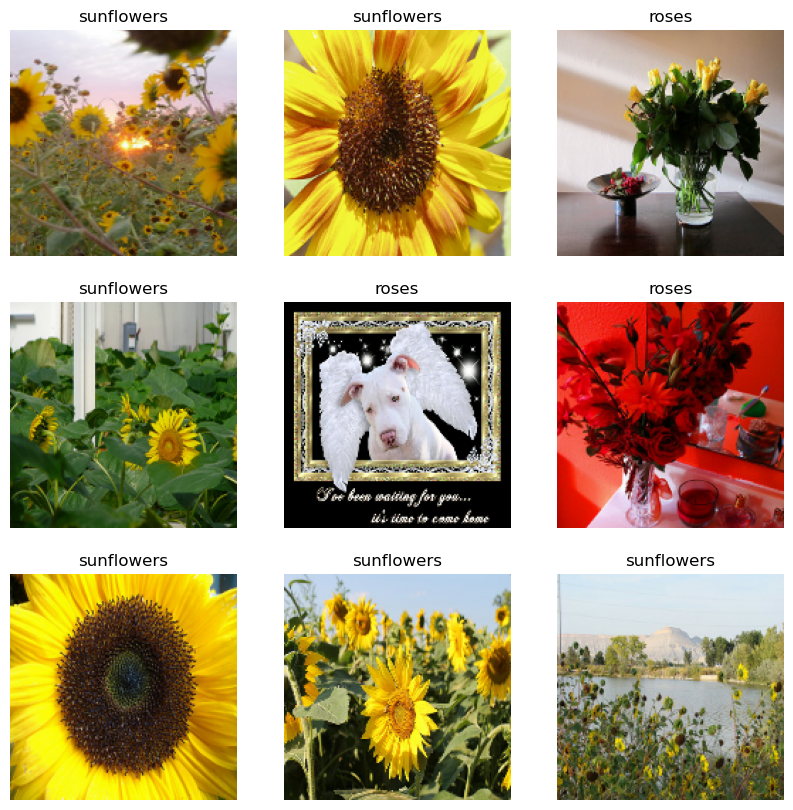

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The original validation dataset is split into two parts -> the validation and test dataset. The test dataset is one-fifth of the original dataset (20%). The remaining data (80%) is the validation data which is used for training. There are 17 batches (17 groups of samples) in the validation dataset. The test dataset is created to evaluate the performance of the model on data which it has not seen before.

In [4]:
val_batches = tf.data.experimental.cardinality(validation_dataset) 
test_dataset = validation_dataset.take(val_batches // 5) 
validation_dataset = validation_dataset.skip(val_batches // 5)

print(val_batches)

tf.Tensor(17, shape=(), dtype=int64)


There are 14 validation batches and 3 test batches. This means there are 224 images in the validation dataset and 48 in the test dataset. 48 images is quite small, but for now it is okay, since the dataset is not too complex or diverse. 

In [5]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 14
Number of test batches: 3


### Configuring the dataset for performance

Prefetching data is a technique that increases the efficiency of loading data for training and evaluation in a machine learning model. It loads data into memory before it's needed, taking advantage of parallel processing to speed up the training process. This can result in a more smooth and faster training and evaluation process for the model. The value of AUTOTUNE is used to dynamically adjust the buffer size for optimal performance based on the available system resources.

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Using data augmentation

On image datasets that are not too large, it is good to use data augmentation. Data augmentation in deep learning is used to increase the diversity of the training dataset. It is done by applying various transformation to the input images (such as rotation, horizontal flipping, zooming). Doing this helps expose the model to different aspects of the training data and reduce overfitting. It does not create extra images in the dataset, but defines a pipeline to apply random transformations during training. <br><br>
A sequential model is used. In the first layer, some of the images in each batch are horizontally flipped. In the second layer, a rotation is applied of max 20%.

In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Let's visualize the images with some transformations.

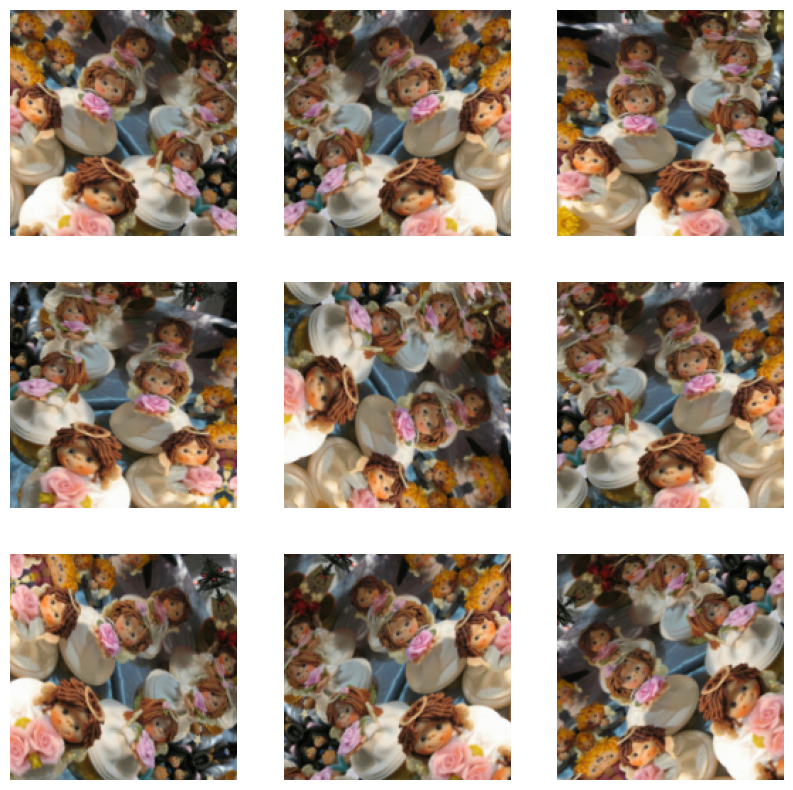

In [8]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescaling pixel values

The pixel values are currently in the images are in [0, 255], but the model expects pixel values in [-1, 1]. The preprocessing method can be used to rescale them to the expected pixel values.

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


A layer is created which rescales the pixel values of an image before feeding it into the model. We divide by 127.5, which is half of 255 (pixels). Offset is set to -1, this means that 1 is subtracted from the result of the division. Setting it to -1 will help to center the pixel values around 0. <br><i>If the range should be [0,1], scale=1./255 would be used without any offset.</i>

In [10]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

### Creating the base model from the pre-trained convnets

A base model is created for the image classification using a pre-trained model MobileNet V2. MobileNet V2 is useful for image classification. It has a high accuracy and efficiency.  The (3,) is to specify to use 3 color channels (red, green, blue). include_top is set to false, which means the final layer of the model (responsible for classification) is not included. weights='imagenet' means that the pre-trained weights for the MobileNet V2 model are used. The pre-trained weights of the MobileNet V2 model are used to improve the performance of the model. I tried using DenseNet as well, to see which model performs better on my dataset. 

In [11]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# # Create the base model from the pre-trained model DenseNet
# IMG_SHAPE = IMG_SIZE + (3,)
# base_model = tf.keras.applications.DenseNet121(input_shape=IMG_SHAPE,
#                                                 include_top=False,
#                                                 weights='imagenet')

A batch of images and their corresponding labels from the training dataset are loaded, passing them through the pre-trained MobileNet V2 model. The result is printed. The output is:
<ul>
    <li>16: the batch size</li>
    <li>5: height of the feature maps in units</li>    
    <li>5: widht of the feature maps in units</li>    
    <li>1280: number of channels in each feature map </li>
</ul>

In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 5, 5, 1280)


## Feature extraction

The base_model.trainable is set to false, which prevents the weights of the model from being updated during training.

In [13]:
base_model.trainable = False

A summary of the model is shown below. It includes information about each layer in the model, such as the name and type of the layer, the output shape of the layer (e.g. (None, 80, 80, 32) -> None is for the batch size, 80 and 80 is for the height and width of the feature map and 32 is for the number of channels in the feature map), number of parameters and to which layer it is connected to.

In [14]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

A global average pooling layer is created using the GlobalAveragePooling2D() function. This layer takes the output of the pre-trained MobileNet V2 model as input. The goal of this is to reduce the dimensionality of the output feature maps from the pre-trained model. The output stands for 16 samples and 1280 channels.

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 1280)


Below, a Dense layer is created for making predictions on the extracted features. This allows the model to make prediction on new, unseen data. 16 stands for the batch size and 1 stands for the number of output units.

In [16]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 1)


Now a new model is used for the pre-trained model. The input is an image of 160x160 pixels in RGB. The data_augmentation is what is specified above (rotation and horizontal flipping). The output of that is used in the pre_process to normalize the pixel values of the image. Then the preprocessed images are going through the pre-trained model, again false is set so the base model's weight stay the same. The global_average_layer is applied. Then a Dropout layer is applied, the dropout rate is set to 20%, this helps to prevent overfitting during training. The model variable is assigned to create the complete model, it takes an input and outputs a single value that represents the probability that the input image is a dog.

In [17]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

Another summary, but now of the new model.

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

We look at the amount of trainable variables. There are 2 in total. After looking at the list, there are 2 trainable variables: the weights and biases.

In [19]:
len(model.trainable_variables)

# for var in model.trainable_variables:
#   print(var.name, var.shape)

2

Somehow this doesn't work, even though pydot and graphviz are installed. I will try to find out why later.

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Here the compiling starts before the training. Several things, such as the optimizer, learning rate, loss, etc. are chosen.
BinaryCrossentropy is used, since there are two classes. A smaller learning rate is better for small datasets to prevent overfitting.

In [21]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

Before training the model, certain variables are specified. We check what the loss and accuracy is of those before training and then we train the model. The epoch means that it passes through the entire training dataset 10 times. The current loss is 74.44% and the accuracy is 46.36% (before training). The higher the loss, the worse the performance is. It means that the difference between the predicted values and the true values is large. The loss is quite high and the accuracy is quite low. 

In [27]:
initial_epochs = 8

loss0, accuracy0 = model.evaluate(validation_dataset)

14/14 [==============================] - 2s 109ms/step - loss: 0.7444 - accuracy: 0.4636


In [28]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.74
initial accuracy: 0.46


Here the training starts. The training and validation loss are quite high at first, but in the end it decreased significantly. The accuracy of both training and validation however increased a lot. This means that the model is learning and improving its performance on both the training and validation data. The loss is significantly low and the accuracy is almost 100%. That is really good.

In [29]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/8


67/67 [==============================] - 15s 160ms/step - loss: 0.6979 - accuracy: 0.5961 - val_loss: 0.5681 - val_accuracy: 0.7227
Epoch 2/8
67/67 [==============================] - 13s 199ms/step - loss: 0.5234 - accuracy: 0.7556 - val_loss: 0.4326 - val_accuracy: 0.8591
Epoch 3/8
67/67 [==============================] - 14s 200ms/step - loss: 0.4111 - accuracy: 0.8377 - val_loss: 0.3352 - val_accuracy: 0.9091
Epoch 4/8
67/67 [==============================] - 13s 199ms/step - loss: 0.3526 - accuracy: 0.8666 - val_loss: 0.2729 - val_accuracy: 0.9364
Epoch 5/8
67/67 [==============================] - 14s 204ms/step - loss: 0.2898 - accuracy: 0.9095 - val_loss: 0.2397 - val_accuracy: 0.9273
Epoch 6/8
67/67 [==============================] - 13s 200ms/step - loss: 0.2475 - accuracy: 0.9254 - val_loss: 0.2199 - val_accuracy: 0.9318
Epoch 7/8
67/67 [==============================] - 14s 209ms/step - loss: 0.2255 - accuracy: 0.9338 - val_loss: 0.1940 - val_accuracy: 0.9409
Epoch 8/8
67/67 

Two plots to visualize the accuracy and loss on the training data and the data it had never seen before (validation) versus epochs. After running the model for 4 epochs, the training and validation start to get closer to each other. This is good, as it means that the model is learning on the new, unseen data.

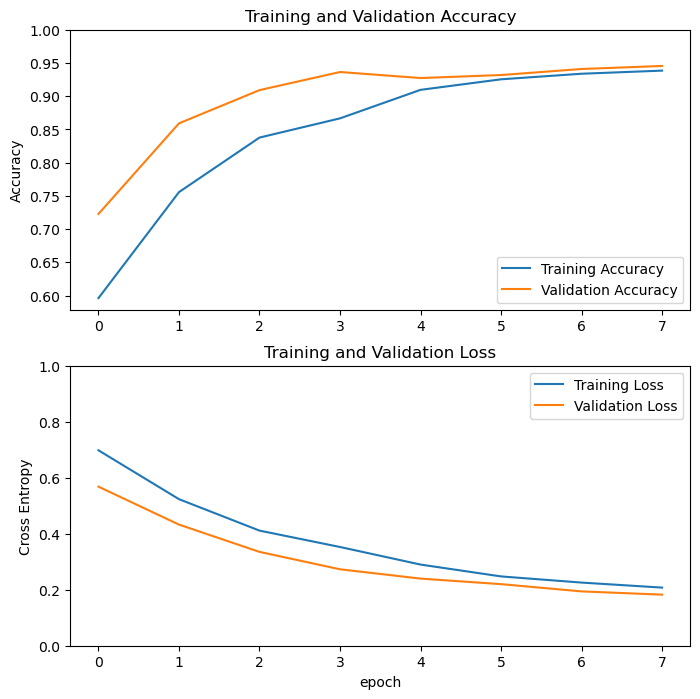

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Let's look at one of the batches to see how accurate the model is, it has 16 images. Out of the 16 images, 1 is incorrectly classified. Let's also visualize this.

Predictions:
 [1 1 1 1 1 1 0 1 1 0 0 1 1 0 0 1]
Labels:
 [1 1 1 0 1 1 0 1 1 0 0 1 1 0 0 1]


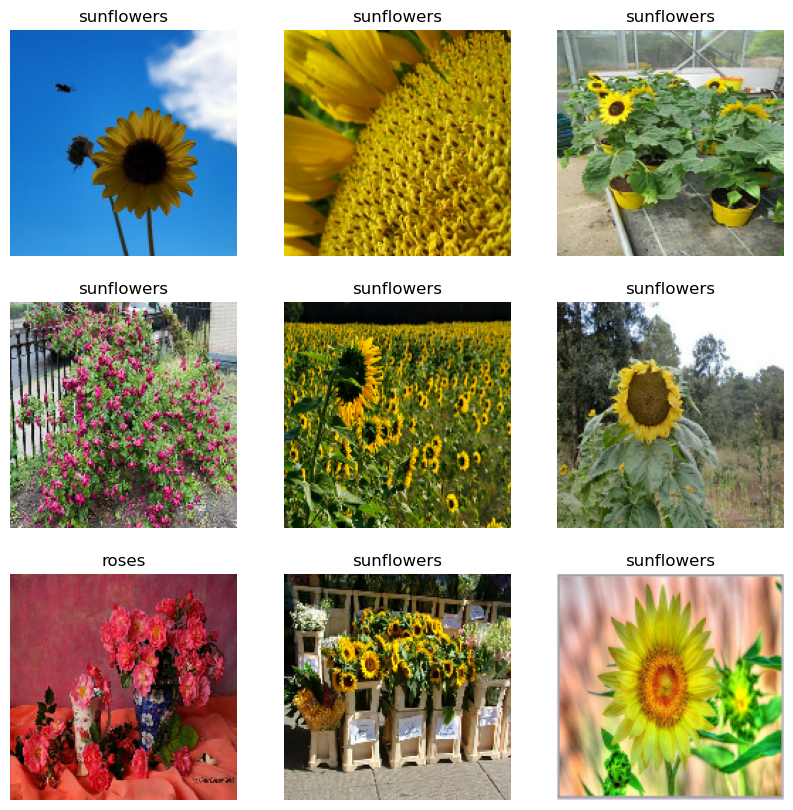

In [33]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

The 4th image is classified as sunflowers, which is interesting as there is no yellow in the image. It probably got confused because it is not zoomed in as much as the roses images usually are. Let's look at a confusion matrix, to see how well the model performed.

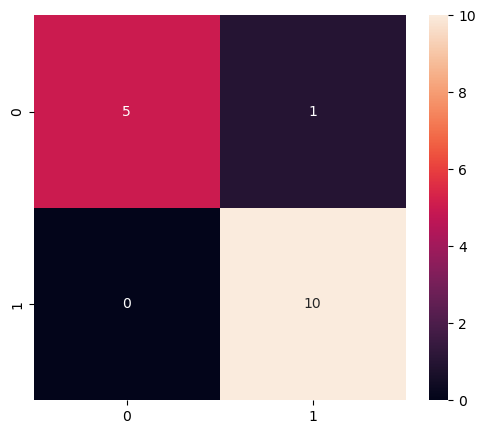

In [34]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(6, 5))
cm = confusion_matrix(label_batch, predictions)
sns.heatmap(cm, annot=True)
plt.show()

In total there were 16 images. As seen above the images, 0 is roses and 1 is sunflowers. 5 roses were correctly classified as roses, 1 rose was incorrectly classified as sunflower, 0 sunflowers were incorrectly classified as roses and 10 sunflowers were correctly classified as sunflowers.

## Conclusion

Eventhough the model is performing quite good, it is better to use more data. This can improve the performance of the model and increase the ability to enhance to new, unseen data.